In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
cd /content/gdrive/My\ Drive/Machine/

/content/gdrive/My Drive/Machine


In [3]:
GCS_PATH="gs://kds-70a543462c41de8ca1833f8f1443deb0910ed11ca81d8356c39c637a" # @param
print(GCS_PATH)

gs://kds-70a543462c41de8ca1833f8f1443deb0910ed11ca81d8356c39c637a


In [4]:
BUFFER_SIZE =   1024    # @param
TRAIN_DATA  =   12000    # @param
TEST_DATA   =   3000    # @param
NB_CLASSES  =          50# @param

TFIDEN      =   'BOCR'  # @param
DATA_FOLDER =   'tfrecords' # @param
DATA_DIM    =        128# @param
NB_CHANNEL  =          1# @param

GCS_PATH=f'{GCS_PATH}/{TFIDEN}/{TFIDEN}/{DATA_FOLDER}'
print(GCS_PATH)



gs://kds-70a543462c41de8ca1833f8f1443deb0910ed11ca81d8356c39c637a/BOCR/BOCR/tfrecords


In [5]:
import tensorflow as tf 
import os 


print(tf.__version__)
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

2.4.1
Running on TPU  grpc://10.61.32.170:8470
INFO:tensorflow:Initializing the TPU system: grpc://10.61.32.170:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.61.32.170:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


In [6]:
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

In [7]:


def data_input_fn(mode): 
    '''
      This Function generates data from gcs
    '''
    
    def _parser(example):
        feature ={  'image'  : tf.io.FixedLenFeature((),tf.string) ,
                    'label'  : tf.io.FixedLenFeature((),tf.int64)
        }    
        parsed_example=tf.io.parse_single_example(example,feature)
        image_raw=parsed_example['image']
        image=tf.image.decode_png(image_raw,channels=NB_CHANNEL)
        image=tf.cast(image,tf.float32)/255.0
        image=tf.reshape(image,(DATA_DIM,DATA_DIM,NB_CHANNEL))
        
        idx = tf.cast(parsed_example['label'], tf.int32)
        label=tf.one_hot(idx,NB_CLASSES,dtype=tf.float32)
        return image,label

    gcs_pattern=os.path.join(GCS_PATH,mode,'*.tfrecord')
    file_paths = tf.io.gfile.glob(gcs_pattern)
    dataset = tf.data.TFRecordDataset(file_paths)
    dataset = dataset.map(_parser)
    dataset = dataset.shuffle(BUFFER_SIZE,reshuffle_each_iteration=True)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE,drop_remainder=True)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset


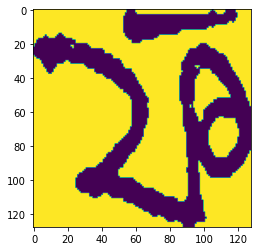

Image Batch Shape: (128, 128, 128, 1)
Target Batch Shape: (128, 50)
tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.], shape=(50,), dtype=float32)


In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

train_ds  =   data_input_fn("train")
test_ds   =   data_input_fn("test")


for x,y in train_ds.take(1):
    data=np.squeeze(x[0])
    plt.imshow(data)
    plt.show()
    print('Image Batch Shape:',x.shape)
    print('Target Batch Shape:',y.shape)
    print(y[0])

**THIS IS CHANGEABLE**

In [9]:
from tensorflow.keras.applications import DenseNet121
with strategy.scope():
    rnet = DenseNet121(
        input_shape=(DATA_DIM,DATA_DIM,NB_CHANNEL),
        weights=None,
        include_top=False
    )
    # trainable rnet
    rnet.trainable = True
    model = tf.keras.Sequential([
        rnet,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(NB_CLASSES, activation='softmax',dtype='float32')
    ])
    model.compile(
        optimizer='adam',
        loss = 'categorical_crossentropy',
        metrics=['categorical_accuracy']
    )

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 4, 4, 1024)        7031232   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 50)                51250     
Total params: 7,082,482
Trainable params: 6,998,834
Non-trainable params: 83,648
_________________________________________________________________


In [10]:
EPOCHS=250 # @param
TOTAL_DATA=TRAIN_DATA+TEST_DATA
STEPS_PER_EPOCH = TOTAL_DATA//BATCH_SIZE
EVAL_STEPS      = TEST_DATA//BATCH_SIZE

**CHANGABLE**

In [11]:
model_name= "model_ocr" # @param
WEIGHT_PATH=os.path.join(os.getcwd(),f'{model_name}.h5') 

# reduces learning rate on plateau
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1,
                                                  cooldown= 10,
                                                  patience=10,
                                                  verbose =1,
                                                  min_lr=0.1e-5)

mode_autosave = tf.keras.callbacks.ModelCheckpoint(WEIGHT_PATH,
                                                  monitor='val_categorical_accuracy', 
                                                  mode = 'max', 
                                                  save_best_only=True, 
                                                  verbose=1, 
                                                  period =1)

# stop learining as metric on validatopn stop increasing
early_stopping = tf.keras.callbacks.EarlyStopping(patience=15, 
                                                  verbose=1, 
                                                  mode = 'auto') 

callbacks = [mode_autosave, lr_reducer,early_stopping ]


In [12]:
history = model.fit(train_ds,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    epochs=EPOCHS,
                    verbose=1, 
                    validation_data=test_ds,
                    validation_steps=EVAL_STEPS,
                    callbacks=callbacks)

Epoch 1/250
117/117 [==============================] - 87s 170ms/step - loss: 2.0208 - categorical_accuracy: 0.4959 - val_loss: 5.0803 - val_categorical_accuracy: 0.0183

Epoch 00001: val_categorical_accuracy improved from -inf to 0.01834, saving model to /content/gdrive/My Drive/Machine/model_ocr.h5
Epoch 2/250
117/117 [==============================] - 10s 85ms/step - loss: 0.2497 - categorical_accuracy: 0.9315 - val_loss: 5.8270 - val_categorical_accuracy: 0.0197

Epoch 00002: val_categorical_accuracy improved from 0.01834 to 0.01970, saving model to /content/gdrive/My Drive/Machine/model_ocr.h5
Epoch 3/250
117/117 [==============================] - 10s 85ms/step - loss: 0.1277 - categorical_accuracy: 0.9668 - val_loss: 6.4397 - val_categorical_accuracy: 0.0197

Epoch 00003: val_categorical_accuracy did not improve from 0.01970
Epoch 4/250
117/117 [==============================] - 10s 85ms/step - loss: 0.0919 - categorical_accuracy: 0.9739 - val_loss: 3.7800 - val_categorical_accur

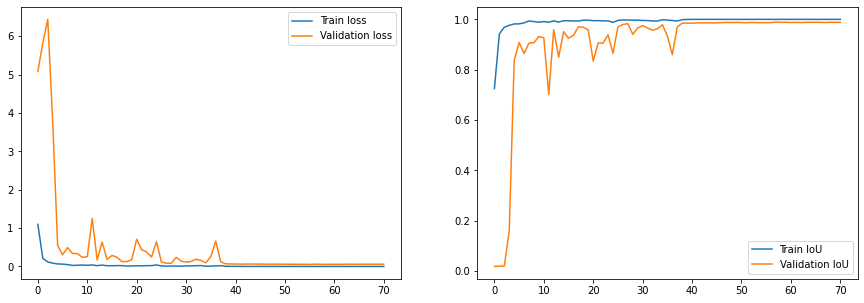

In [13]:
model.load_weights(WEIGHT_PATH)


def plot_history(history):
    """
    Plots model training history 
    """
    fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
    ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
    ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax_loss.legend()
    ax_acc.plot(history.epoch, history.history["categorical_accuracy"], label="Train IoU")
    ax_acc.plot(history.epoch, history.history["val_categorical_accuracy"], label="Validation IoU")
    ax_acc.legend()
    plt.show()

    # show history
plot_history(history)

In [15]:
ls -la

total 97619
drwx------ 2 root root     4096 Feb 11 10:43 data/
-rw------- 1 root root    93407 Feb  8 09:31 Hand_digit.ipynb
-rw------- 1 root root 13038896 Feb 11 10:35 model.h5
-rw------- 1 root root 85903856 Feb 11 15:10 model_ocr.h5
-rw------- 1 root root   920600 Feb 11 15:13 train.ipynb


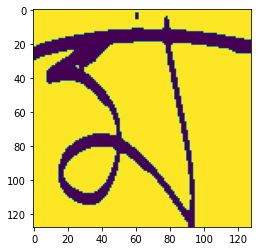

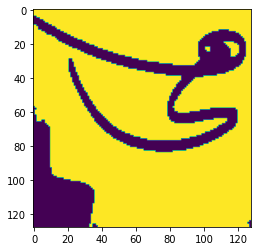

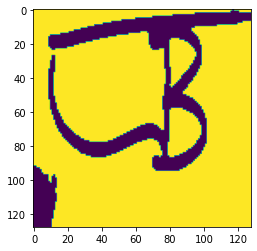

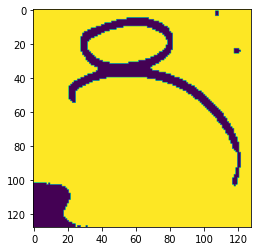

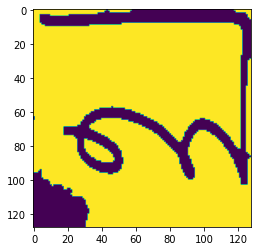

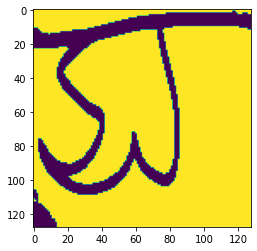

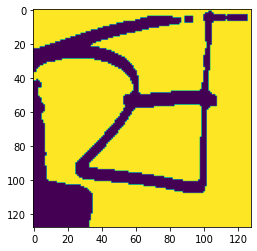

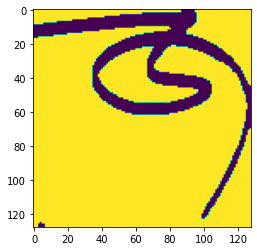

8


In [31]:
import cv2
from glob import glob 
data=[]
def stripPads(arr,val):
    '''
        strip specific values
    '''
    arr=arr[~np.all(arr == val, axis=1)]
    arr=arr[:, ~np.all(arr == val, axis=0)]
    return arr

for img_path in glob(os.path.join(os.getcwd(),'data','*.*')):
  img=cv2.imread(img_path,0)
  # Otsu's thresholding after Gaussian filtering
  blur = cv2.GaussianBlur(img,(5,5),0)
  _,img = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  img  =stripPads(img,255)
  img = img/255
  img = 1 - img
  img = cv2.dilate(img,(3,3),iterations = 80)
  img=cv2.resize(img,(DATA_DIM,DATA_DIM))
  img = 1 -img
  img = img*255
  img=img.astype('uint8')
  # Otsu's thresholding after Gaussian filtering
  blur = cv2.GaussianBlur(img,(5,5),0)
  _,img = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  plt.imshow(img)
  plt.show()
  img=np.expand_dims(img,axis=-1)
  img=np.expand_dims(img,axis=0)
  data.append(img)

  
print(len(data))


**TPU SPECIAL NEED**

In [29]:
for i in range(8-len(data)):
  data.append(data[0])

In [32]:
data=np.vstack(data)
data=data/255.0
data.shape

(8, 128, 128, 1)

In [33]:
preds=model.predict(data)
preds.shape

(8, 50)

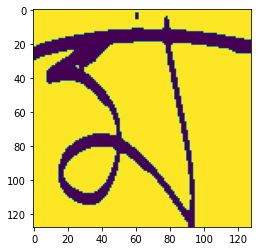

ম


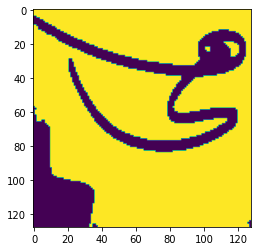

ঊ


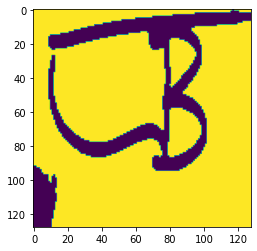

ঞ


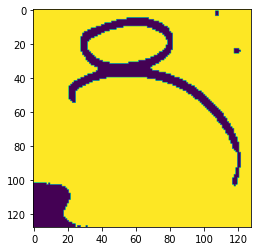

ং


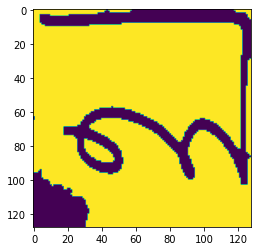

ল


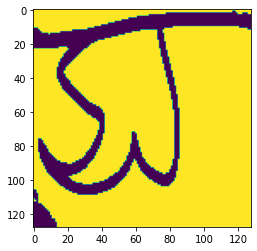

স


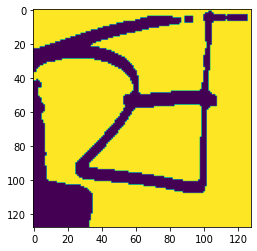

ষ


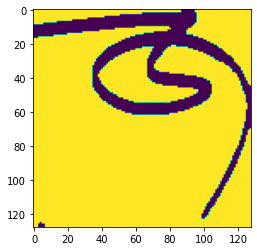

জ


In [35]:
labels=['অ','আ','ই','ঈ','উ','ঊ',  
'ঋ','এ','ঐ','ও','ঔ',  
'ক','খ','গ','ঘ','ঙ',  
'চ','ছ','জ','ঝ','ঞ',  
'ট','ঠ','ড','ঢ','ণ',  
'ত','থ','দ','ধ','ন',  
'প','ফ','ব','ভ','ম',  
'য','র','ল',  
'শ','ষ','স','হ',  
'ড়','ঢ়','য়',  
'ৎ','ং','ঃ','ঁ']
for pred,img in zip(preds,data):
  img=img*255
  img=img.astype('uint8')
  plt.imshow(np.squeeze(img))
  plt.show()
  print(labels[np.argmax(pred)])
  